##### Our project tries to predict whether a user will spend on money on a website or not.
It is a simple yes or no calculation.
The data was taken from a kaggle competition given here : [devfest21](https://www.kaggle.com/c/devfest21-competition)

In [78]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

In [96]:
testFilePath = "../test_cleaned.csv"
trainFilePath = "../train_cleaned.csv"
validationFilePath = "../validation_cleaned.csv"

# Open as pd dataframe
train = pd.read_csv(trainFilePath)
test = pd.read_csv(testFilePath)
validation = pd.read_csv(validationFilePath)

train.dropna(how = "any", inplace=True)
test.dropna(how = "any", inplace=True)
validation.dropna(how = "any", inplace=True)

In [80]:
# Convert dataframes to numpy arrays
trainY = train["Revenue"].to_numpy()
trainX = train.drop(columns=["Revenue"]).to_numpy()

testY = test["Revenue"].to_numpy()
testX = test.drop(columns=["Revenue"]).to_numpy()

validationY = validation["Revenue"].to_numpy()
validationX = validation.drop(columns=["Revenue"]).to_numpy()

Make a simple boosting model

In [81]:
clf = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.05, max_depth = 7, random_state = 0).fit(trainX, trainY)
clf.score(testX, testY)

0.8861256544502618

Show variable importances in the model we just created

<AxesSubplot:>

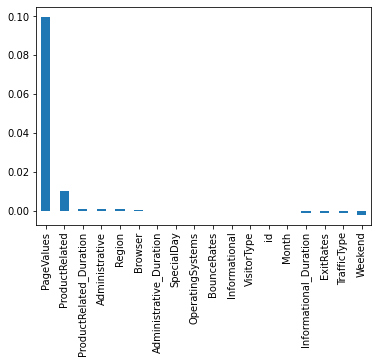

In [82]:
importances_mean = permutation_importance(clf, testX, testY, n_repeats=10, random_state=0)["importances_mean"]
# Convert np array to series
importances_mean = pd.Series(importances_mean, index=train.drop(columns=["Revenue"]).columns)
importances_mean.sort_values(ascending=False).plot(kind="bar")

Subset selection: Using forward search

In [83]:
# GREEDY COLUMN OPTIMIZATION FOR BOOSTING
# Tries each column in isolation, picks the best one. Then tries to add a column by doing the same

columns = list(train.drop(columns=["Revenue"]).columns)

# Optimisation by adding just one feature at a time

scores = [0]
finalScores = []
prevScore = -1
currColumns = []
availableColumns = columns[1:]

# We want to keep adding columns until we can't improve the score anymore
while max(scores) > prevScore:

    prevScore = max(scores)
    scores = []

    # Try each column in isolation will current columns
    for i in range(len(availableColumns)):
        useColumns = currColumns.copy()
        useColumns.append(availableColumns[i])

        trainX = train.loc[:, useColumns].to_numpy()
        clf = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.1, max_depth = 5, random_state = 0).fit(trainX, trainY)

        testX = test.loc[:, useColumns].to_numpy()
        scores.append(clf.score(testX, testY))

        print("For columns: " + str(useColumns) + " score: " + str(scores[-1]))


    # ADD THE BEST COLUMN
    maxIndex = scores.index(max(scores))
    if(max(scores) > prevScore):
        print("Selected column " + str(availableColumns[maxIndex]))
        # add column to currColumns
        currColumns.append(availableColumns[maxIndex])
    
    else:
        print("No more improvement\nSelected columns: " + str(currColumns))

    # remove column from availableColumns
    availableColumns.remove(availableColumns[maxIndex])
    finalScores.append(scores)

For columns: ['Administrative'] score: 0.8448952879581152
For columns: ['Administrative_Duration'] score: 0.8085732984293194
For columns: ['Informational'] score: 0.8475130890052356
For columns: ['Informational_Duration'] score: 0.8288612565445026
For columns: ['ProductRelated'] score: 0.8409685863874345
For columns: ['ProductRelated_Duration'] score: 0.7977748691099477
For columns: ['BounceRates'] score: 0.8321335078534031
For columns: ['ExitRates'] score: 0.818717277486911
For columns: ['PageValues'] score: 0.8668193717277487
For columns: ['SpecialDay'] score: 0.8478403141361257
For columns: ['Month'] score: 0.8478403141361257
For columns: ['OperatingSystems'] score: 0.8478403141361257
For columns: ['Browser'] score: 0.8478403141361257
For columns: ['Region'] score: 0.8478403141361257
For columns: ['TrafficType'] score: 0.8478403141361257
For columns: ['VisitorType'] score: 0.8478403141361257
For columns: ['Weekend'] score: 0.8478403141361257
Selected column PageValues
For columns: [

Hyper parameter tuning: manually using for loops

In [84]:
# PARAMETER OPTIMISATION FOR BOOSTING
trainY = train["Revenue"].to_numpy()
trainX = train.drop(columns=["Revenue"]).to_numpy()

testY = test["Revenue"].to_numpy()
testX = test.drop(columns=["Revenue"]).to_numpy()

depths = [ 4, 5, 6, 7, 8, 9, 10]
ns = [200, 300, 400, 500, 600, 700, 800, 1000, 1500]
scores = []
for n in ns:
    for depth in depths:
        clf = GradientBoostingClassifier(n_estimators = n, learning_rate = 0.1, max_depth = depth, random_state = 0).fit(trainX, trainY)
        i_accuracy = clf.score(trainX, trainY)
        oos_accuracy = clf.score(testX, testY)
        scores.append((n, depth, oos_accuracy))
        # print("For n = " + str(n) + " and depth = " + str(depth) + " accuracy is " + str(oos_accuracy))
        
# Get max score
maxScore = max(scores, key=lambda x: x[2])
print("The best parameters are n = " + str(maxScore[0]) + " and depth = " + str(maxScore[1]))

The best parameters are n = 300 and depth = 4


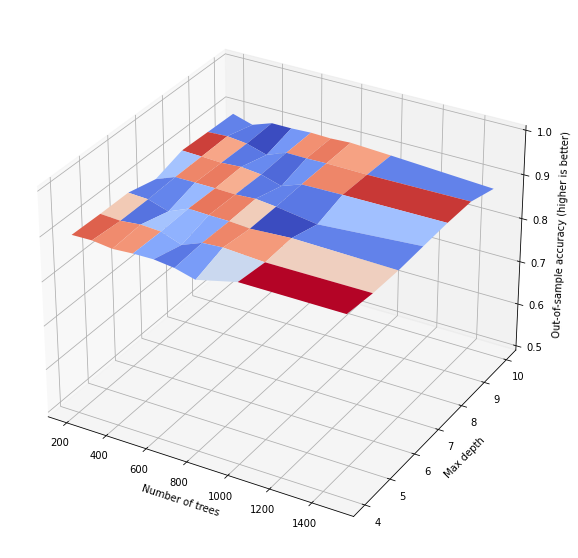

In [88]:
# Plot a surface with x = n and y = depth and z = oos_accuracy
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10, 10))

X, Y = np.meshgrid(ns, depths)
Z = np.array([s[2] for s in scores]).reshape(len(depths), len(ns))

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth = 0 ) 
ax.set_zlim(0.5, 1)   
# xlabel
ax.set_xlabel('Number of trees')
# ylabel
ax.set_ylabel('Max depth')
# zlabel
ax.set_zlabel('Out-of-sample accuracy (higher is better)')
plt.show()

Hyper parameter tuning: Using GridSearchCV
<br>
Does cross validation and is much faster!

In [89]:
# Use gridsearchcv to find the best parameters
# Answers differ from above, because of cross validation; Also error reported here is from train set
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[200,300,400,500,600,700,800,1000,1500], 'learning_rate':[0.1], 'max_depth':[4,5,6,7,8,9,10]}

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=2, n_jobs=8, scoring='accuracy')
clf.fit(trainX, trainY)
print(clf.best_params_)
print(clf.best_score_)

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1500}
0.9236931626098714


Get validation accuracy score

In [99]:
# Use the best paramters and subset selection

# Remove some irrelevant columns such as id
train = train[["PageValues", "ProductRelated_Duration", "BounceRates", "Month", "TrafficType", "Revenue"]]
test = test[["PageValues", "ProductRelated_Duration", "BounceRates", "Month", "TrafficType", "Revenue"]]
validation = validation[["PageValues", "ProductRelated_Duration", "BounceRates", "Month", "TrafficType", "Revenue"]]

trainY = train["Revenue"].to_numpy()
trainX = train.drop(columns=["Revenue"]).to_numpy()

testY = test["Revenue"].to_numpy()
testX = test.drop(columns=["Revenue"]).to_numpy()

validationY = validation["Revenue"].to_numpy()
validationX = validation.drop(columns=["Revenue"]).to_numpy()

# We can merge train and test sets and predict on validation set
X = np.concatenate((trainX, testX), axis=0)
Y = np.concatenate((trainY, testY), axis=0)

clf = GradientBoostingClassifier(n_estimators = 1500, learning_rate = 0.1, max_depth = 7, random_state = 0).fit(X, Y)
clf.score(validationX, validationY)

0.8526717557251908

Generate the hidden data set predictions:<br>
The predictions can be submitted [here](https://www.kaggle.com/competitions/devfest21-competition/submissions)

In [103]:
train = pd.read_csv('../train_1.csv')
test = pd.read_csv('../test_1.csv')

# Convert month to a number
def convertMonth(month):
    lookup = {
        "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "June": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
    }
    return lookup[month]

def convertVisitorType(visitorType):
    lookup = {
        "Returning_Visitor": 0,
        "New_Visitor": 1,
        "Other": 2
    }
    return lookup[visitorType]

train["Month"] = train["Month"].map(convertMonth)
train["VisitorType"] = train["VisitorType"].map(convertVisitorType)

test["Month"] = test["Month"].map(convertMonth)
test["VisitorType"] = test["VisitorType"].map(convertVisitorType)
train.dropna(how = "any", inplace=True)

trainY = train["Revenue"].to_numpy()



In [104]:
train2 = train[["PageValues", "ProductRelated_Duration", "BounceRates", "Month", "TrafficType"]]
test2 = test[["PageValues", "ProductRelated_Duration", "BounceRates", "Month", "TrafficType"]]

train2 = train2.to_numpy()
test2 = test2.to_numpy()

clf = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, max_depth=6)
clf.fit(train2, trainY)

# Write to a csv file write revenue as int
submission = pd.DataFrame({"id": test["id"], "Revenue": clf.predict(test2).astype(int)})
# write to a csv file
submission.to_csv("submission1.csv", index=False)